# `SpectralModel`

Written by [Doriann Blain](mailto:doriann.blain@gmail.com).

The goal of this notebook is to give an introduction to the possibilites offered by `SpectralModel`.

We make some useful imports below.

In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS.physical_constants as cst

## Introduction

`SpectralModel` objects are just like `Radtrans` objects (the former is actually a child of the latter). However, with `SpectralModel`, all of the steps required to build a forward model can be taken care of internally by [built-in functions](#Built-in-functions). This includes, for example, calculating the temperature profile, or the mean molar mass. Then, the spectrum is calculated via the relevant `Radtrans` functions. The output can then be [modified](#Spectral-modifications-in-details) by, for example, applying a convolution, or shifting the wavelengths.

Below is a flowchart of what is happening when calculating a spectrum using the `SpectralModel.calculate_spectrum` function.

<img src="images/flowchart.drawio.svg">

The terms used in this flowchart are defined below.

### Model parameters

Model parameters are the parameters of the [model functions](#Model-functions) and of the [spectral modification functions](#Spectral-modification-functions). They are set when instantiating a `SpectralModel`.

Examples: `temperature`, `imposed_mass_fractions`, etc.

See the sections below for more details

<div class="alert alert-info">
    
Model parameters of a `SpectralModel` instance can be accessed with e.g. `spectral_model.model_parameters`. They can be [modified without instanciating a new object](#Modifying-model-parameters-without-instatiating-a-new-SpectralModel).
</div>

<div class="alert alert-info">
    
The list of available default model parameters can be accessed by calling the `get_default_parameters` function of a `SpectralModel` instance, e.g. `spectral_model.get_default_parameters()`. A detailed documentation is available on the [reference API](../../autoapi/petitRADTRANS/spectral_model/index.html).
</div>

### Model functions

Model functions are the functions calculating the [spectral parameters](#Spectral-parameters) and the [modification parameters](#Modification-parameters). By default, `SpectralModel` comes with a number of [built-in model functions](#Built-in-functions), starting with `compute_`. For example, `SpectralModel.compute_temperature` or `SpectralModel.compute_mass_fractions`. They are automatically executed with `SpectralModel.calculate_spectrum`.

<div class="alert alert-info">

The built-in model functions can be modified at runtime, and new/additional model functions can be added to a `SpectralModel` objects. The model functions execution order is automatically determined using a [topological sorting algorithm](https://en.wikipedia.org/wiki/Topological_sorting). See [section "Modifying the model functions and the spectral modification functions"](#Modifying-the-model-functions-and-the-spectral-modification-functions).
</div>

### Spectral parameters

Spectral parameters are all parameters necessary to calculate a spectrum with the `Radtrans` [spectral functions](#Spectral-functions), i.e. these latter functions' arguments. For example the temperature profile (`temperatures`), the mass fractions (`mass_fractions`), etc.

### Modification parameters

Modification parameters are a subcategory of [model parameters](#Model-parameters) to refer specifically to the parameters of the [spectral modification functions](#Spectral-modification-functions). They are set when instantiating a `SpectralModel`.

Examples on a default `SpectralModel`: `convolve_resolving_power`, `rebinned_wavelengths`, etc.

See [section "Calculating a time-varying high-resolution spectrum"](#Calculating-a-time-varying-high-resolution-spectrum) for more details.


<div class="alert alert-warning">

The deprecated `'modification_parameters'` key of in the `model_parameters` dict contains the `calculate_spectrum` **modification arguments** (`scale`, `shift`, `noise_matrix`, etc.), and **not** "modification parameters" as defined here. Modification parameters, just as model parameters, are key/value pairs in the `model_parameters` dict.
</div>

### Spectral functions

Spectral functions are simply the `Radtrans` functions `calculate_flux` and `calculate_transit_radii`.

### Spectral modification functions

Spectral modifications functions are the functions modifying the he spectrum after its generation with `Radtrans`, for example to convolve or shift it. See [section "Calculating a time-varying high-resolution spectrum"](#Calculating-a-time-varying-high-resolution-spectrum) for more details.

## Basic usage

In this section we will cover the most basic usage of `SpectralModel`, that is, using it as a regular `Radtrans` object.

`SpectralModel` is imported as follows:

In [2]:
from petitRADTRANS.spectral_model import SpectralModel

Let's start out by creating a `SpectralModel` object. 

This will simply load the requested opacities and create an object ready to calculate spectra.

In [3]:
spectral_model = SpectralModel(
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2--H2', 'H2--He'],
    wavelength_boundaries=[0.3, 15]
)

Loading Radtrans opacities...
 Done.ng line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable.petitRADTRANS.h5'

As you can see, this `SpectralModel` was initialised in the exact same way as a `Radtrans` object. However, it is more interesting to use the extra features of `SpectralModel` that we will touch below.

## Calculating a transmission spectrum

Here we will generate the same transmission spectrum as in the ["Getting Started" section](./getting_started.html): the transmission spectrum of a hot Jupiter with an isothermal temeprature profile and constant mass fractions. However, we will make full use of the `SpectralModel` features.

The first step is to instantiate a `SpectralModel` object, including some necessary [model parameters](#Model-parameters).

In [4]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2--H2', 'H2--He'],
    wavelength_boundaries=[0.3, 15],
    # Model parameters
    # Planet parameters
    planet_radius=1 * cst.r_jup_mean,
    reference_gravity=10 ** 3.5,
    reference_pressure=1e-2,
    # Temperature profile parameters
    temperature=1200,  # isothermal temperature profile
    # Mass fractions
    imposed_mass_fractions={  # these can also be arrays of the same size as pressures
        'H2O': 1e-3,
        'CO-NatAbund': 1e-2,
        'CH4': 1e-5,
        'CO2': 1e-4,
        'Na': 1e-4,
        'K': 1e-6
    },
    filling_species={  # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12
        'H2': 37, 
        'He': 12
    }
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Done.ng line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable.petit

Arguments like `temperature`, `imposed_mass_fractions` and `filling_species` are [model parameters](#Model-parameters). They are used as inputs to the `SpectralModel` [model functions](#Model-functions). 

In contrast with the `Radtrans` example, we did not give the mean molar mass of the atmosphere. This is because `SpectralModel` used a built-in model function (`spectral_model.compute_mean_molar_masses`) to calculate it from the mass fractions. We also did not directly set the $\rm H_2$ and $\rm He$ mass fractions, because we used the `filling_species` model parameter (see [section "Mass fractions and mean molar masses"](#Mass-fractions-and-mean-molar-masses)).

Let's calculate the spectrum. The returned wavelengths and transit radii are in cm.

<div class="alert alert-warning">

If you are using petitRADTRANS versions < 3.1.0, add `update_parameters=True` in the function below. See [section "Not updating parameters"](#Not-updating-parameters) and [this issue](https://gitlab.com/mauricemolli/petitRADTRANS/-/issues/88).
</div>

In [5]:
wavelengths, transit_radii = spectral_model.calculate_spectrum(
    mode='transmission'
)

Let's now plot the transit radius.

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

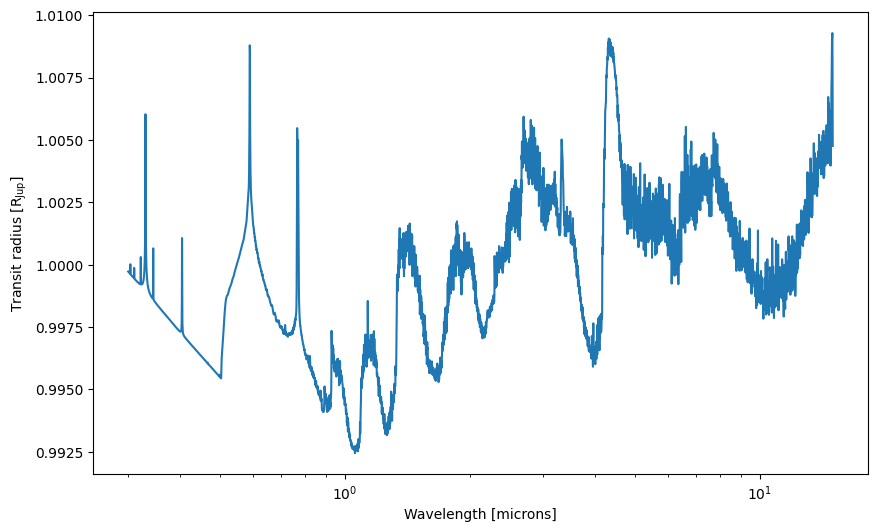

In [6]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii[0] / cst.r_jup_mean)
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

## Calculating an emission spectrum

Emission spectra usually require more complex temperature profiles and mass fraction profiles than transmission spectra to accurately fit the data. Here we will introduce: 

- Another default `SpectralModel` temperature profile: the [Guillot 2010](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G) temperature profile introduced in the Getting Started section (see [section "Temperature profiles"](#Temperature-profiles)).
- The `SpectralModel`'s behaviour with mass fractions (see [section "Mass fractions and mean molar masses"](#Mass-fractions-and-mean-molar-masses)), we will use [equilibrium chemistry](./interpolating_chemical_equilibrium_abundances.ipynb).
- Additional model parameters, relevant for emission spectra modelling.

In order to show the default behaviour of `SpectralModel` regarding mass fractions and filling species, and manually set an unphysical $\rm H_2O$ mass fraction profile (with abundances > 1).

Let's first generate our `SpectralModel`.

In [7]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2--H2', 'H2--He'],
    wavelength_boundaries=[0.3, 15],
    scattering_in_emission=True,  # replace do_scat_emis from pRT2
    # SpectralModel parameters
    # Planet parameters
    planet_radius=1 * cst.r_jup_mean,
    reference_gravity=10 ** 3.5,
    reference_pressure=1e-2,
    # Star, system, orbit
    is_observed=True,  # return the flux observed at system_distance
    is_around_star=True,  # if True, calculate a PHOENIX stellar spectrum and add it to the emission spectrum
    system_distance=10 * cst.s_cst.light_year * 1e2,  # m to cm, used to scale the spectrum
    star_effective_temperature=5500,  # used to get the PHOENIX stellar spectrum model
    star_radius=1 * cst.r_sun,  # used to get the star flux irradiating the planet
    orbit_semi_major_axis=0.05 * cst.au,  # used to get the star flux irradiating the planet
    # Temperature profile parameters
    temperature_profile_mode='guillot',
    temperature=1500,
    intrinsic_temperature=200,
    guillot_temperature_profile_gamma=0.4,
    guillot_temperature_profile_infrared_mean_opacity_solar_metallicity=0.01,
    # Mass fractions
    use_equilibrium_chemistry=True,
    metallicity=3,  # times solar
    co_ratio=0.1,
    imposed_mass_fractions={
        'H2O': np.logspace(1, -12, 100)  # we use a H2O mass fraction > 1 to demonstrate how SpectralModel deals with it
    },
    filling_species={  # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12, H2/Ne = 37/0.06
        'H2': 37, 
        'He': 12,
        'Ne': 0.06
    }
)

Loading Radtrans opacities...
 Done.ng line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable.petit

There are 2 parameters in particular that may require further explanation:

- `is_observed`: if `True`, return `flux * (planet_radius / system_distance) ** 2` instead of just `flux`. This is only used in emission mode.
- `is_around_star`: if `True`, calculate a PHOENIX stellar spectrum and use it to compute the emission spectrum (which will then contain a contribution of the scattered stellar light if scattering is turned on). This is used only in emission mode. This has the same effect as adding stellar parameters to `calculate_flux()` when using a `Radtrans` object directly, see ["Scattering for Emission Spectra"](scattering_for_emission_spectra.html#Scattering-of-stellar-light).

<div class="alert alert-info">

**Adding stellar spectra:** to add stellar spectra, setting both `star_effective_temperature` and `star_radius` is sufficient, `is_around_star` can be left to `False`. Indeed, this has the same effect than setting these parameters when calling `Radtrans.calculate_flux()`. Setting `is_around_star=True` generates a unique stellar spectrum that will be used both as scattered ligth in the emission spectrum and as the scaling spectrum with  `scale=True`. See [section "Scaling"](#Scaling).
</div>

Let's now calculate the spectrum.

In [8]:
wavelengths, flux = spectral_model.calculate_spectrum(
    mode='emission'
)

Loading PHOENIX star table in file '/home/dblain/petitRADTRANS/input_data/stellar_spectra/phoenix/phoenix.startable.petitRADTRANS.h5'... Done.
Done.ng chemical equilibrium chemistry table from file '/home/dblain/petitRADTRANS/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... 


Now let's plot the spectrum. Note the scattered stellar light at small wavelengths.

Text(0, 0.5, 'Observerved planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

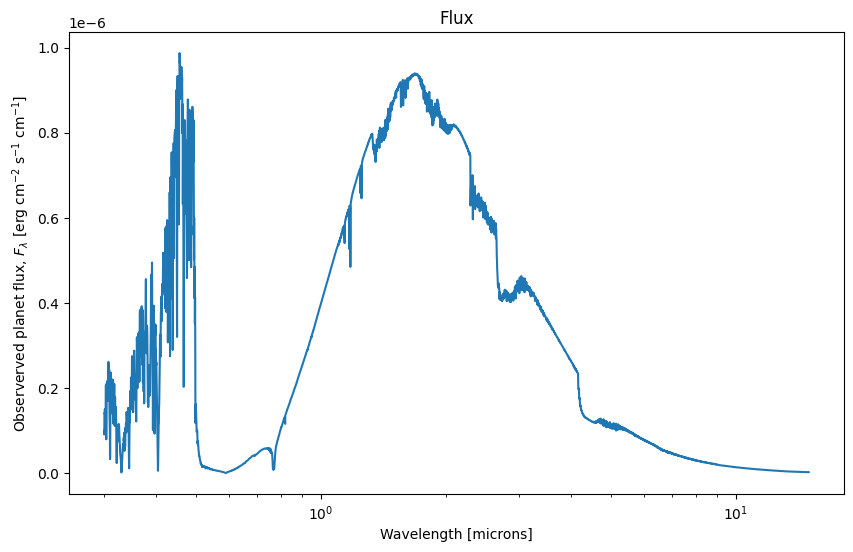

In [9]:
fig, ax = plt.subplots(figsize = (10,6))

ax.semilogx(wavelengths[0] * 1e4, flux[0])

ax.set_title('Flux')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Observerved planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

Let's save this `SpectralModel` for later uses.

In [10]:
spectral_model_emission = copy.deepcopy(spectral_model)

## Calculating a time-varying high-resolution spectrum

Let's now introduce more advanced `SpectralModel` features: the spectral modification parameters. We will do this by going through the calculation of a time-varying high-resolution spectrum.

<div class="alert alert-info">

In this example, we will generate a transmission spectrum, but everything mentioned here also works for emission spectra.
</div>

### Introduction: Doppler-shifting and relative velocity

`SpectralModel` can generate time-varying models. This includes most importantly changes in the relative velocity between the observer and the planet. At low resolution this effect is usually negligible as the spectral lines are not resolved. At high resolution, taking this effect into account is crucial.

In `SpectralModel`, the shifted wavelengths $\lambda$ of the source (the planet) is obtained from the wavelengths in the rest frame of the source ($\lambda_0$) following:

\begin{equation}
\lambda = \lambda_0 \sqrt{\frac{1 + V / c}{1 - V / c}}.
\end{equation}

The `relative_velocities` ($V$), are calculated in `SpectalModel` following this equation:

\begin{equation}
V(t) = \sqrt{\frac{G M_\ast}{a_p}} \sin(i_p) \sin(2 \pi \phi(t)) + V_\textrm{sys}(t) + V_\textrm{bary}(t) + V_\textrm{rest}.
\end{equation}

<center><img src="images/transit_velocities.drawio.svg" width=600></center>

The first term is the planet radial velocity around its star relative to the observer. During the observation, the planet rotates around the star, so its radial velocity relative to the observer will change. It is composed of the planet radial velocity semi-amplitude, often called $K_p$, multiplied by the $\sin$ of the orbital longitude (i.e. $2\pi$ time the **orbital phase**, $\phi$). In `SpectralModel`, $K_p$ can be given (`radial_velocity_semi_amplitude`), or calculated using:

- `star_mass` ($M_\ast$),
- `orbit_semi_major_axis` ($a_p$),
- `orbital_inclination` ($i_p$, optional, $90^\circ$ by default).

We also need to take the motion of the star relative to the observer into account. In `SpectralModel`, this [model parameter](#Model-parameters) is called `system_observer_radial_velocities`. It is usually divided into 2 components:

- The radial velocity between the planet's system barycenter and the barycenter of the solar system (`star_radial_velocity`, $V_\textrm{sys}$)
- The relative velocity between the observer and the barycenter of the solar system (`barycentric_velocities`, $V_\textrm{bary}$)

The last term of the equation is a correction term `rest_frame_velocity_shift` ($V_\textrm{rest}$) to the total velocity. This can be used as a proxy to model the effect of atmospheric winds, for example.

### Loading a `Planet`

It can be convenient to use the [Planet object](./planet.ipynb) to get the parameters we need. Note that this is not required.

In [11]:
from petitRADTRANS.planet import Planet

planet = Planet.get('HD 189733 b')

### Initializing a time-varying transmission spectrum

We will generate mock data wavelengths and times below. We will assume that we observed 19 exposures. To keep things simple, we will assume that `star_radial_velocity` is fixed, and `barycentric_velocities` varies linearly. We will fix `rest_frame_velocity_shift` to -5 km.s-1, and let `SpectralModel` calculate $K_p$ for us.

<div class="alert alert-info">

For real data, the `barycentric_velocities` parameter can also be obtained using `planet.calculate_barycentric_velocities`. See the documentation on the [Planet object](./planet.ipynb).
</div>

In [12]:
from petitRADTRANS.math import resolving_space

n_exposures = 19

data_wavelengths = resolving_space(1.519, 1.522, 2e5) * 1e-4 # (cm) generate wavelengths at a constant resolving power
times = 0.85 * planet.transit_duration * (np.linspace(0, 1, n_exposures) - 0.5)  # covering 85% of the transit duration
orbital_phases = times / planet.orbital_period
mid_transit_time = 0  # (s)
star_radial_velocity = planet.star_radial_velocity  # (cm.s-1) V_sys
barycentric_velocities = np.linspace(-13.25e5, -13.55e5, times.size)  # (cm.s-1) V_bary

# Uncertainties assuming a S/N of 2000
data_uncertainties = 5e-4 * np.ones((1, n_exposures, data_wavelengths.size))

Now let's initalize our `SpectralModel`. We will add an opaque cloud layer at 100 mbar. Our instrument will have a resolving power of $R = 80\,000$.

<div class="alert alert-info">

**Model parameter** `wavelength_boundaries`**:** if you provide parameters such as the wavelengths of your data (`rebinning_wavelengths`), you no longer need to manually set `wavelength_boundaries`: `SpectralModel` will automatically calculate the optimal wavelengths boundaries for your data, taking into account the effect of time-varying Doppler-shift.
</div>

We will use `planet` to get some of the required parameters. 

We will introduce a few new model parameters, that will be described in more detail in the next sections.

In [13]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CO-NatAbund', 
        'H2O' 
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2--H2', 'H2--He'],
    line_opacity_mode='lbl',
    line_by_line_opacity_sampling=4,
    # SpectralModel parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=1e-2,
    star_radius=planet.star_radius,
    transit_duration=planet.transit_duration,
    orbital_period=planet.orbital_period,
    # Velocity paramters
    star_mass=planet.star_mass,
    orbit_semi_major_axis=planet.orbit_semi_major_axis,
    orbital_inclination=planet.orbital_inclination,
    rest_frame_velocity_shift=-5e5,  # (cm.s-1) V_rest
    system_observer_radial_velocities=star_radial_velocity - barycentric_velocities,
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=1e-2,  # added opaque cloud
    # Mass fractions
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CO-NatAbund': 1e-2,
        'H2O': 1e-3,
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=data_wavelengths,  # (cm) used for the rebinning, and also to set the wavelengths boundaries
    rebin_range_margin_power=4,  # used to set the wavelengths boundaries, adding a margin of ~1 Angstrom (1e-4 * ~1 µm)
    convolve_resolving_power=8e4,  # used for the convolution
    mid_transit_time=mid_transit_time,
    times=times,
    # Preparation parameters
    tellurics_mask_threshold=0.8,  # mask the fitted transmittances if it is below this value
    polynomial_fit_degree=2,  # degree of the polynomial fit
    uncertainties=data_uncertainties
)

Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__POKAZATEL.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2--H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2--He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully lo

### Modifying the spectrum

To generate an exploitable time-varying model, we need to do several operations, in that order:

1. [Scale](#Scaling) the transit radii to the planet's star radius.
2. [Doppler-shift](#Shifting) the spectra at each exposure, in order to take the relative velocity (that needs to be calculated as well) between the planet and the observer into account.
3. Take into account the [transit light loss](#Transit-effect) due to the planet's ingress and egress.
4. [Convolve](#Convolving) the spectrum to the instrument's LSF.
5. [Rebin](#Re-binning) the spectrum to the instrument's wavelengths.

<div class="alert alert-info">
    
Additional modifications, useful to simulate data, can be realised (see [section "Tellurics, deformations, and noise"](#Tellurics,-deformations,-and-noise)).
</div>

With `SpectralModel`, these steps can be done easily, by adding some arguments to the `calculate_spectrum` function:

In [14]:
wavelengths_rebinned, transit_radii = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True,  # scale the spectrum
    shift=True,  # Doppler-shift the spectrum to the planet's radial velocities relative to the observer
    use_transit_light_loss=True,  # apply the effect of transit ingress and egress
    convolve=True,  # convolve to the instrument's resolving power
    rebin=True  # rebin to the instrument's wavelengths
)

Let's take a look at the outputs dimensions.

In [15]:
print(f"The shape of the rebinned wavelengths is {wavelengths_rebinned.shape}")
print(f"The shape of the rebinned transit_radii is {transit_radii.shape}")

The shape of the rebinned wavelengths is (1, 395)
The shape of the rebinned transit_radii is (1, 19, 395)


The `transit_radii` has one dimension to store respectively, the spectral **orders**, the **exposures** and the **wavelengths**. The wavelengths `wavelengths_rebinned` has one dimension to store respectively, the spectral **orders**, the **wavelengths**. In general, the instrument's wavelengths of reduced data is the same across exposures. 

The `data_wavelengths` had 1 dimension, so `SpectralModel` assumed that we had 1 order. To add more orders, `data_wavelengths` should have 2 dimensions, the first one corresponding to the spectral orders, and the second to the wavelengths.

Let's now plot the spectrum. Since we have one order, we can plot `transit_radii[0]`, which varies along exposures and wavelengths.

Text(0, 0.5, 'Orbital phase')

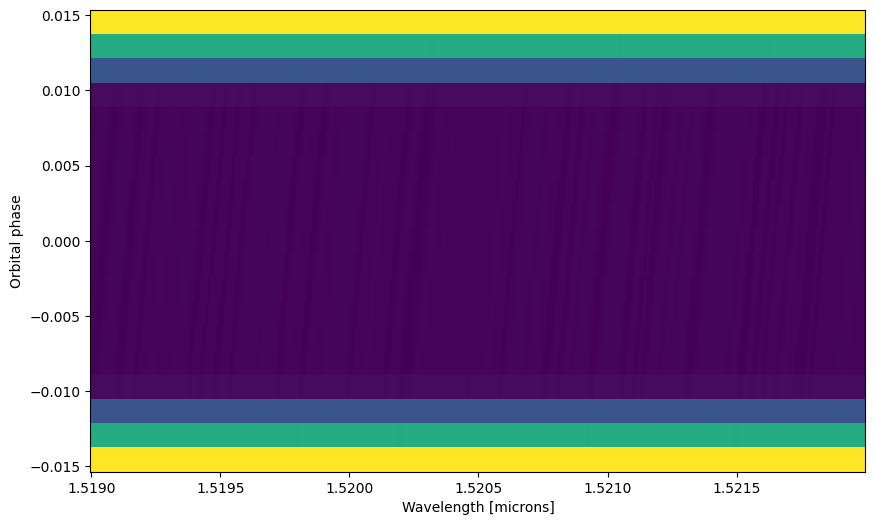

In [16]:
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, transit_radii[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')

<div class="alert alert-info">
    
You can use the modifications arguments (`convolve`, `rebin`, etc.) in any combination (e.g., only `rebin`, only `scale` and `convolve`, etc.)
</div>

Let's save this `SpectralModel` for later uses.

In [17]:
spectral_model_high_resolution = copy.deepcopy(spectral_model)

## Built-in functions

In this section we will use the `SpectralModel` we built for the [emission spectrum](#Calculating-an-emission-spectrum).

In [18]:
spectral_model = spectral_model_emission

### Temperature profiles

<div class="alert alert-info">

The temperature profile calculation is by default controlled by the function `compute_temperatures`.
</div>

By default, two temperature profile modes are available, controlled by the `temperature_profile_mode` [model parameter](#Model-parameters):

- An isothermal temperature profile, by default or if `temperature_profile_mode='isothermal'`.
- The Guillot 2010 temperature profile, if `temperature_profile_mode='guillot'`.

In the `'guillot'` case, the `temperature` [model parameter](#Model-parameters) refer to the equlibrium temperature. 

We can plot the temperature profile obtained by `SpectralModel`. This is almost the same Guillot temperature profile than in the getting started section. 

<div class="alert alert-info">

The profile is slightly warmer because the atmosphere's metallicity is super solar (`metallicity=3`). By default, with `SpectralModel`, the `infrared_mean_opacity` of the Guillot profile is equal to `metallicity * guillot_temperature_profile_infrared_mean_opacity_solar_metallicity`
</div>

Text(0, 0.5, 'P [bar]')

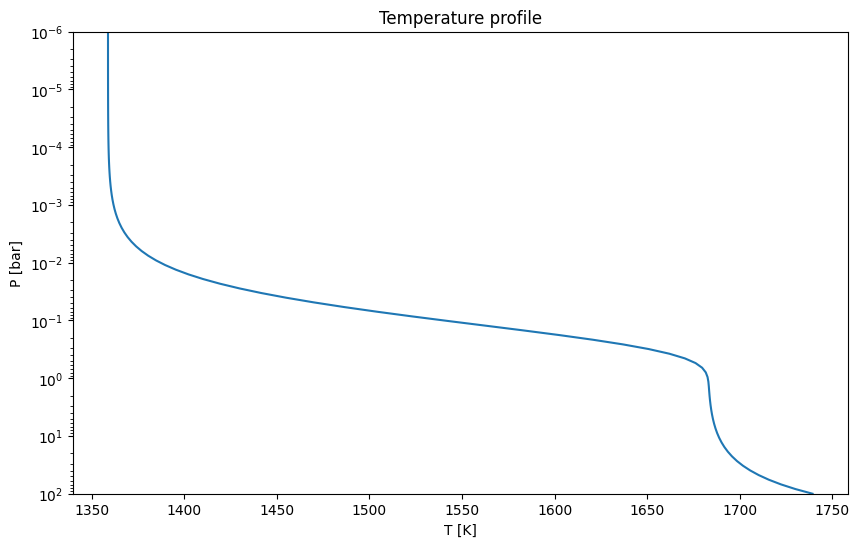

In [19]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(spectral_model.temperatures, spectral_model.pressures * 1e-6)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_title('Temperature profile')
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')

### Mass fractions and mean molar masses

<div class="alert alert-info">

The mass fractions calculation is by default controlled by the function `compute_mass_fractions`.
</div>

<div class="alert alert-info">

The mean molar mass calculation is by default controlled by the function `compute_mean_molar_masses`.
</div>

We can plot the mass fractions and see `SpectralModel`'s default behaviour.

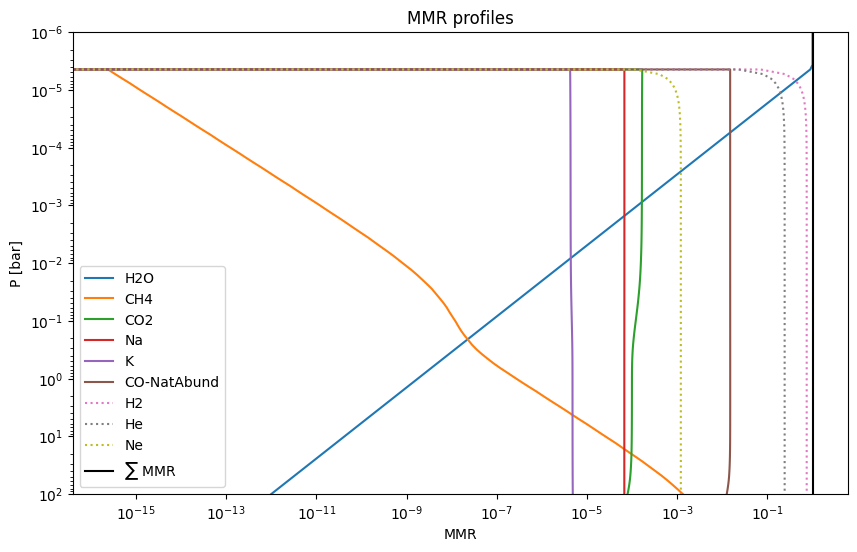

In [20]:
fig, ax = plt.subplots(figsize = (10,6))

for species, mass_fraction in spectral_model.mass_fractions.items():
    if species in spectral_model.line_species:
        ax.loglog(mass_fraction, spectral_model.pressures * 1e-6, label=species)

for species, mass_fraction in spectral_model.mass_fractions.items():
    if species in spectral_model.model_parameters['filling_species']:
        ax.loglog(mass_fraction, spectral_model.pressures * 1e-6, label=species, ls=':')

ax.loglog(np.sum(list(spectral_model.mass_fractions.values()), axis=0), spectral_model.pressures * 1e-6, label=r'$\sum$ MMR', color='k')
    
ax.set_ylim([1e2, 1e-6])
ax.set_title('MMR profiles')
ax.set_xlabel('MMR')
ax.set_ylabel('P [bar]')
ax.legend()

Here we can see the priorities of `SpectralModel`, by default:
1. Always ensure that the sum of MMR is 1.
2. Ensure that the imposed mass fractions are strictly respected, unless their sum is > 1.
3. Ensure that the equilibrium chemistry mass fractions are respected, unless they conflict with the imposed mass fractions.
4. Ensure that the filling species ratios are respected, unless they conflict with the above.

While $\rm H_2O$ is by default in the `PreCalculatedEquilibriumChemistryTable` (that we requested with `use_equilibrium_chemistry=True`), we overrode its mass fraction by using `imposed_mass_fractions`.

Above $10^{-5}$ bar ("deep" atmosphere), the sum of equilibrium mass fractions and imposed mass fractions are < 1, so the filling species are added to the atmosphere, according to their requested ratios.

Between $10^{-5}$ bar and $5 \times 10^{-6}$ bar ("upper" atmosphere), the imposed amount of $\rm H_2O$ has increased so much that the sum of mass fractions excluding filling species is significantly closer to 1. Hence, filling species are not as necessary, so their abundances collapse. Equilibrium chemistry species are not yet affected.

Below $5 \times 10^{-6}$ bar ("top" of the atmosphere), the imposed amount of $\rm H_2O$ is capped to 1 because it is not physical to have mass fractions > 1. Since imposed mass fractions have priority over equilibrium chemistry species, their abndances are decreased, preserving their ratios. Here, the $\rm H_2O$ mass fraction reaches 1 very quickly, so their mass fractions are directly set to 0. The transition is more visible in the next section.

Note that while the key `'CO-NatAbund'` is not in the `PreCalculatedEquilibriumChemistryTable`, `SpectralModel` automatically linked it to the `'CO'` key.

<div class="alert alert-info">

**Model parameter** `filling_species`**:** this model parameter is used to automatically fill the atmosphere with the given species, with the requested weights, without changing the `imposed_mass_fractions`, and such that the sum of mass fractions is equal to 1. The filling species can be modified at will (e.g. `{'N2': 78, 'O2': 21, 'CO2': 0.5, 'H2': 0.5, 'Xe': 25}`, priority is always given to the `imposed_mass_fractions`). The weights are proportional to the relative mass fractions between the filling species. They do not have to be normalized. Here, we set the H2/He ratio to 37/12, which is approximately the ratio found in Jupiter.  Alternatively, `filling_species` can be set to `None` (its default value), and the `H2` and `He` mass fractions can be added manually to `imposed_mass_fractions`.
</div>

We can also plot the mean molar masses (MMW).

Text(0, 0.5, 'P [bar]')

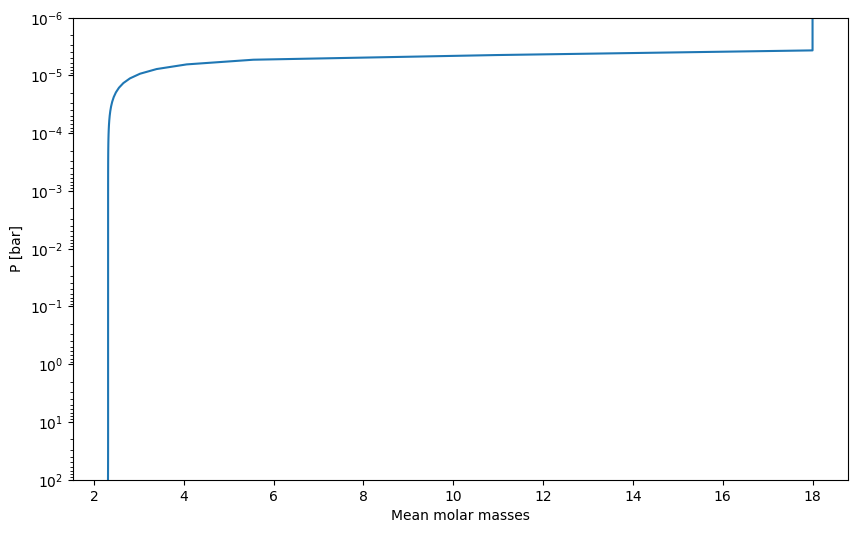

In [21]:
fig, ax = plt.subplots(figsize = (10,6))

ax.semilogy(spectral_model.mean_molar_masses, spectral_model.pressures * 1e-6, label=species)

ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('Mean molar masses')
ax.set_ylabel('P [bar]')

Starting with the expected MMW for a jupiter-like $\rm H_2$/$\rm He$ atmosphere, as $\rm H_2O$ becomes the dominant species, the MMW increases until it takes on the $\rm H_2O$ molar mass value where the $\rm H_2O$ mass fraction is 1.

## Spectral modifications in details

In the sections below we will explain the effect of each new `calculate_spectrum` argument more in-depth. We will use the `SpectralModel` we built for high-resolution spectra.

In [22]:
spectral_model = spectral_model_high_resolution

### Spectrum without modification

If we calculated the transit radii as we did in the [transmission spectrum section](#Calculating-a-transmission-spectrum), we would generate only a single spectrum for one exposure. This is triggered by `shift = False`, which is the default value.

In [23]:
wavelengths, transit_radii_not_modified = spectral_model.calculate_spectrum(
    mode='transmission'
)

Text(0, 0.5, 'Transit radius [cm]')

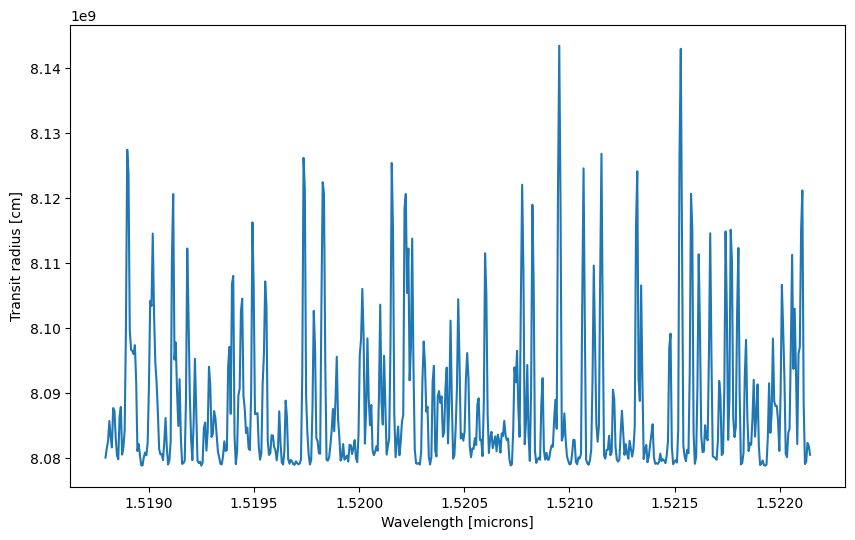

In [24]:
# Plot the spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii_not_modified[0])  # [0] is used to get the 1st and only exposure
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [cm]')

### Scaling

<div class="alert alert-info">

The scaling is controlled by the function `scale_spectrum`. Spectral modification function map key: `scale`.
</div>

Here "scaling" refer to modifying the spectrum such that it is expressed relative to its planet's star's spectum.

For transiting planets, the data collected are a combination of the star's spectrum ($F_\ast$) and the planet's spectrum ($F_p$). 

For emission spectra, the observed spectrum before or after the ("secondary") eclipse ($F_\mathrm{obs}$) can be expressed as:
\begin{equation}
F_{\mathrm{obs}} = F_\ast + F_p.
\end{equation}
The stellar spectrum can be acquired independently during the planet's actual ("secondary") eclipse, to obtain the **scaled** spectrum (after subtracting 1):
\begin{equation}
F_{\mathrm{scaled}} = F_{\mathrm{obs}}/F_\ast -1 = F_p / F_\ast.
\end{equation}
In `SpectralModel`, the scaled emission spectrum is:
```python
spectrum /= star_observed_spectrum
```
where `star_observed_spectrum` is the re-binned spectrum obtained from the `compute_star_flux` function (PHOENIX/ATLAS9 model by default), observed at `system_distance` assuming a star radius of `star_radius`.

In transmission ("primary" eclipse), the observed spectrum during transit ($F_\mathrm{obs}$) can be expressed as a function of the planet (spectral) radius ($R_p$, aka the "transit radius") and the star radius ($R_\ast$):
\begin{equation}
F_{\mathrm{obs}} = F_\ast (1 - R_p / R_\ast)^2.
\end{equation}
Similarly, the **scaled** spectrum can be obtained by dividing with the star spectrum:
\begin{equation}
F_{\mathrm{scaled}} = 1 - (R_p / R_\ast)^2.
\end{equation}
In `SpectralModel`, the scaled transmission spectrum is:
```python
spectrum = 1 - (spectrum / star_radius) ** 2
```
since spectrum is the planet's transit radius.

To activate the scaling, set `scale=True`:

In [25]:
wavelengths, transit_radii_scaled = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True
)

Text(0, 0.5, 'Scaled transit spectrum [arbitrary units]')

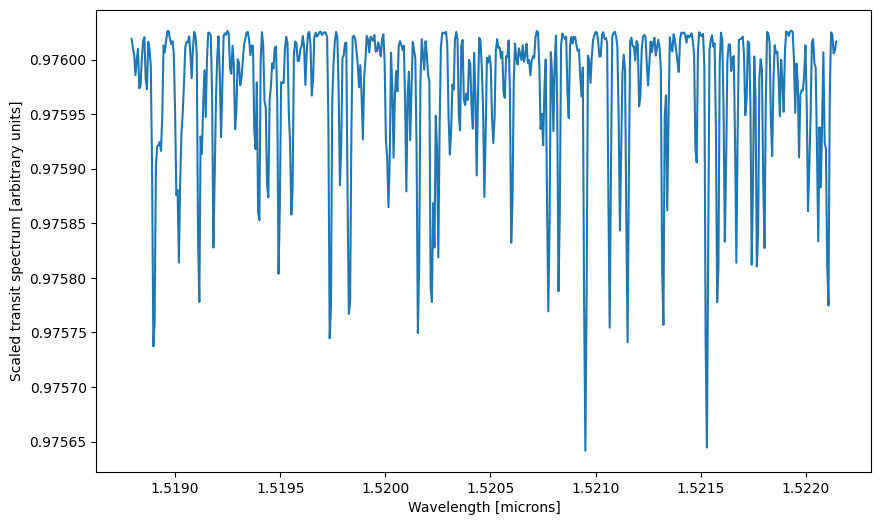

In [26]:
# Plot the spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii_scaled[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Scaled transit spectrum [arbitrary units]')

### Shifting

<div class="alert alert-info">

The shifting is controlled by the function `shift_wavelengths`. Spectral modification function map key: `shift`.
</div>

Now let's add Doppler-shifts the spectrum add the time dimension to our model.

To activate the shifting, set `shift=True`:

In [27]:
wavelengths_shifted, transit_radii_shifted = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True,
    shift=True
)

The `transit_radii` and `wavelengths` shapes has been modified.

In [28]:
print(f"The shape of the shifted wavelengths is {wavelengths_shifted.shape}")
print(f"The shape of the shifted transit_radii is {transit_radii_shifted.shape}")

The shape of the shifted wavelengths is (19, 552)
The shape of the shifted transit_radii is (19, 552)


Now, instead of assuming 1 exposure as before, we have 1 spectrum for each of our 19 exposures, each with a spectrum Doppler-shifted at a different **relative velocity**. The relative velocities has been calculated by the built-in model function `compute_relative_velocities`.

Now let's plot the relative velocities `SpectralModel` calculated.

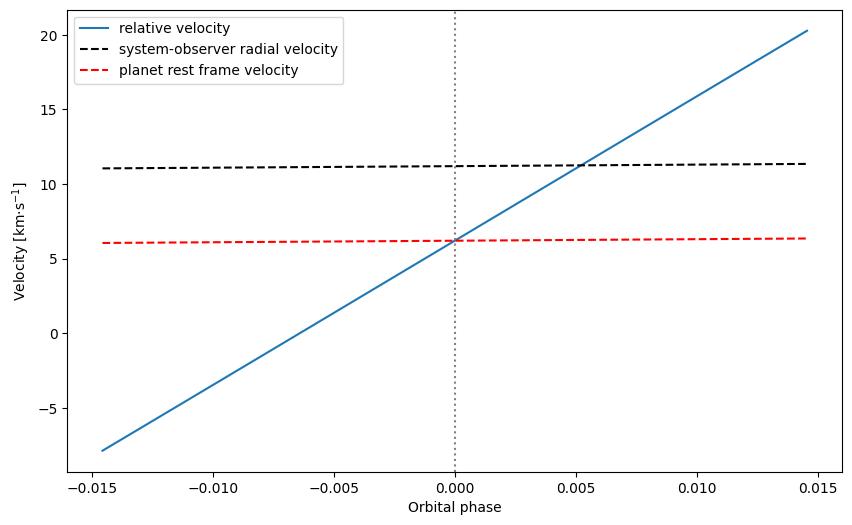

In [29]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(
    orbital_phases,
    spectral_model.model_parameters['relative_velocities'] * 1e-5,  # (cm.s-1 to km.s-1)
    label='relative velocity'
)

# Plot visual indicators
ax.plot(
    orbital_phases, 
    spectral_model.model_parameters['system_observer_radial_velocities'] * 1e-5,  # cm.s-1 to km.s-1
    ls='--', color='k', label='system-observer radial velocity'
)
ax.plot(
    orbital_phases, 
    (spectral_model.model_parameters['system_observer_radial_velocities'] + spectral_model.model_parameters['rest_frame_velocity_shift']) * 1e-5, 
    ls='--', color='r', label='planet rest frame velocity'
)

y_lim = ax.get_ylim()

ax.vlines(0, y_lim[0], y_lim[1], color='grey', ls=':')
ax.set_xlabel('Orbital phase')
ax.set_ylabel(r'Velocity [km$\cdot$s$^{-1}$]')
ax.set_ylim(y_lim)
ax.legend()

Now let's plot the spectra. We will plot 3 of them for clarity.

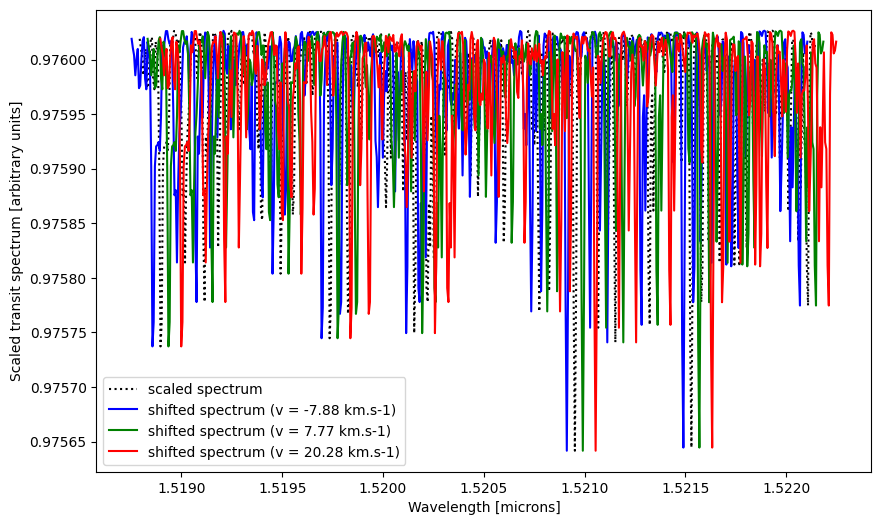

In [30]:
# Select 3 exposures to plot
exposures_to_plot = [
    0,
    10,
    -1
]

# Set the 3 spectrum colors in the plot
colors = [
    'b',
    'g',
    'r'
]

# Plot the un-shifted spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(
    wavelengths[0] * 1e4, transit_radii_scaled[0], 
    label='scaled spectrum', color='k', ls=':'
)

# Plot the shifted spectra
for i, exposure in enumerate(exposures_to_plot):
    ax.plot(
        wavelengths_shifted[exposure] * 1e4, transit_radii_shifted[exposure], 
        label=f"shifted spectrum (v = {spectral_model.model_parameters['relative_velocities'][exposure] * 1e-5:.2f} km.s-1)", color=colors[i]
    )
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Scaled transit spectrum [arbitrary units]')
ax.legend()

### Convolving

<div class="alert alert-info">

The convolution is controlled by the function `convolve`. Spectral modification function map key: `convolve`.
</div>

Let's now add a convolution to the spectral modification, to better represent the instrument's line-spread function (LSF). The LSF is the function you'd measure with the spectrograph with inifitesimally small pixels if the spectrum contained only one line of zero width (i.e., a $\delta$ function). The LSF thus caracterizes how the spectrograph disperses light as a function of wavelength. By default, `SpectralModel` uses a Gaussian kernel and the parameter `convolve_resolving_power` that we provided. `convolve_resolving_power` is defined as $\lambda/\Delta\lambda$, where $\lambda$ is the wavelength, and $\Delta\lambda$ the width of the spectrograph's resolution element.

To activate the shifting, set `convolve=True`:

In [31]:
wavelengths_shifted, transit_radii_shifted_convolved = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True,
    shift=True,
    convolve=True
)

Let's plot the spectrum at one exposure.

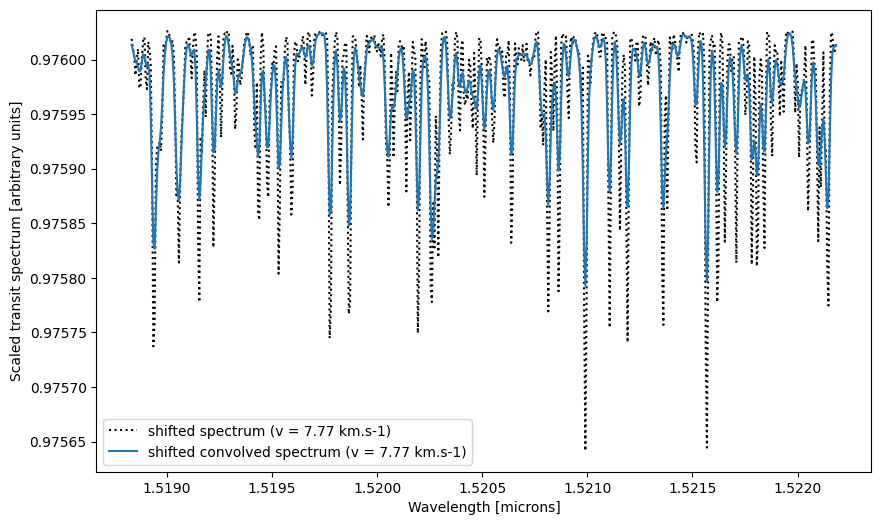

In [32]:
exposure_to_plot = 10 

# Plot the spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(
    wavelengths_shifted[exposure_to_plot] * 1e4, transit_radii_shifted[exposure_to_plot], 
    label=f"shifted spectrum (v = {spectral_model.model_parameters['relative_velocities'][exposure_to_plot] * 1e-5:.2f} km.s-1)", color='k', ls=':'
)
ax.plot(
    wavelengths_shifted[exposure_to_plot] * 1e4, transit_radii_shifted_convolved[exposure_to_plot], 
    label=f"shifted convolved spectrum (v = {spectral_model.model_parameters['relative_velocities'][exposure_to_plot] * 1e-5:.2f} km.s-1)"
)
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Scaled transit spectrum [arbitrary units]')
ax.legend()

### Re-binning

<div class="alert alert-info">

The re-binning is controlled by the function `rebin_spectrum`. Spectral modification function map key: `rebin`.
</div>

Let's now re-bin the spectrum to the data wavelengths (which are ultimately defined by the pixel position and width on the detector) in order to be able to compare our model with the data properly.

To activate the shifting, set `rebin=True`:

In [33]:
wavelengths_rebinned, transit_radii_rebinned = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True,
    shift=True,
    convolve=True,
    rebin=True
)

The shapes of `transit_radii` and `wavelengths` have changed again.

In [34]:
print(f"The shape of the rebinned wavelengths is {wavelengths_rebinned.shape}")
print(f"The shape of the rebinned transit radii is {transit_radii_rebinned.shape}")

The shape of the rebinned wavelengths is (1, 395)
The shape of the rebinned transit radii is (1, 19, 395)


Let's plot the spectra.

Text(0, 0.5, 'Orbital phase')

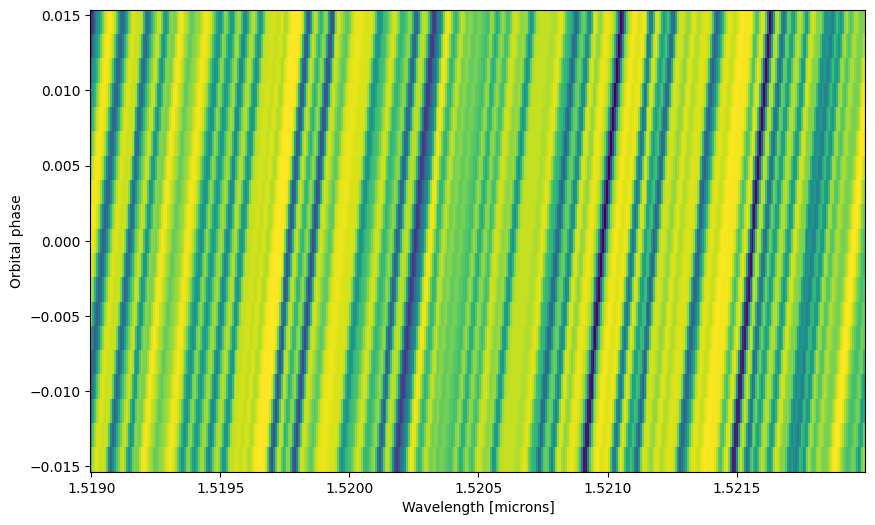

In [35]:
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, transit_radii_rebinned[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')

### Transit effect

<div class="alert alert-info">

The transit effect is controlled by the function `compute_transit_fractional_light_loss`. Spectral modification function map key: `use_transit_light_loss`.
</div>

During a primary transit, the planet's disk is not always fully superimposed on the star's disk. This means that the transit depth during ingress and egress is smaller than during the full transit. In `SpectralModel`, this is done with the built-in function `compute_transit_fractional_light_loss`, which is based on [Mandel & Agol (2002)](https://www.doi.org/10.1086/345520) (Eq. 1), and uses the model parameters `transit_duration` ($T_{14}$) and `orbital_period` ($P$)..

<div class="alert alert-warning">

The limb-darkening effect is currently **not** taken into account in the default `compute_transit_fractional_light_loss` function.
</div>

We can calculate the spectrum to obtain the same result as at the [start of this section](#initializing).

In [36]:
wavelengths_rebinned, transit_radii_final = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True
)

Text(0.5, 1.0, 'Spectrum at 1.52050 microns')

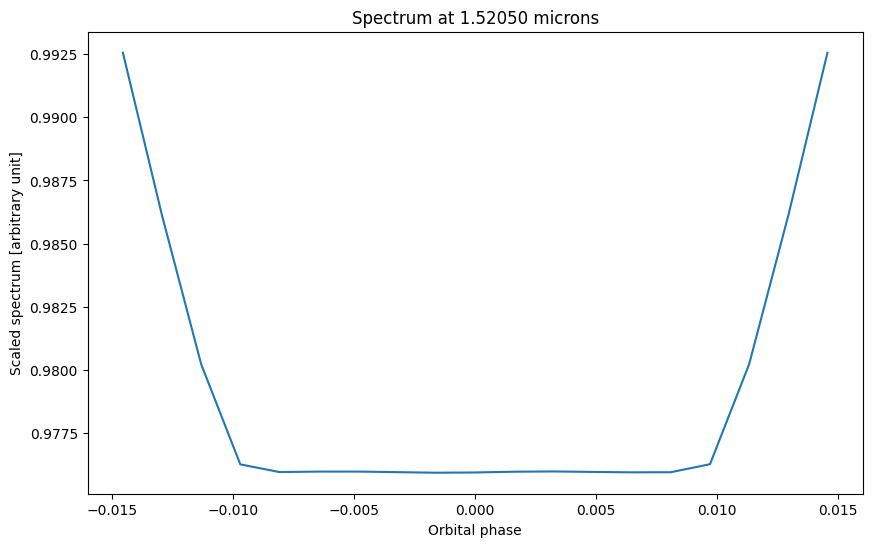

In [37]:
# Plot the spectra across times at one wavelength
fig, ax = plt.subplots(figsize = (10,6))

wavelength_id = int(transit_radii_final.shape[-1] / 2)
ax.plot(orbital_phases, transit_radii_final[0, :, wavelength_id])
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Scaled spectrum [arbitrary unit]')
ax.set_title(f"Spectrum at {wavelengths_rebinned[0, wavelength_id] * 1e4:.5f} microns")

## Tellurics, deformations, and noise

To build simulated data, we can add telluric transmittances, setllar lines, instrumental deformations, and noise. To do this, we can make use of the following arguments:

- `telluric_transmittances`: telluric transmittances to combine with the spectrum. Those can make use of the `airmass` model parameter to automatically build time- and wavelength-varying transmittances. A good place to download telluric transmittances is the [SKYCALC](https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) website. petitRADTRANS also has a module to directly download SKYCALC data, calculate the airmass, and even find the best day for your observations in the module `petitRADTRANS.cli.eso_skycalc_cli`.
- `telluric_transmittances_wavelengths`: wavelengths of the provided telluric transmittances.
- `instrumental_deformations`: time and wavelength matrix of the instrumental deformations. Must be of shape `(n_orders, n_exposures, n_wavelengths)`.
- `noise_matrix`: time and wavelength matrix of noise. Must be of shape `(n_orders, n_exposures, n_wavelengths)`.

The detailed `SpectralModel` modification flowchart in that case is:

1. [scale](#Scaling), [shift](#Shifting), then add the [transit effect](#Transit-effect),
2. Rebin the `telluric_transmittances` to the current wavelengths, then multiply them to the spectra,
3. [Convolve](#Convolving), then [rebin](#Re-binning) the spectra,
4. Multiply the spectra with the `instrumental_deformations`,
5. Add the `noise_matrix` to the spectra.

Below is an example, using simplistic `telluric_transmittances`:

In [38]:
# High resolution telluric transmittances (typically downloaded from SKYCALC)
# If we add airmass information, as we do below, the transmittance here needs to be given at airmass == 1.
telluric_transmittances_wavelengths = resolving_space(1.515, 1.525, 1e6) * 1e-4
telluric_transmittances = np.ones(telluric_transmittances_wavelengths.size)

# Add simplisitc lines
telluric_transmittances[2850:2870] = 0.85
telluric_transmittances[2900:2930] = 0.7
telluric_transmittances[3400:3500] = 0.1
telluric_transmittances[3900:3950] = 0.5
telluric_transmittances[4400:4475] = 0.3

# Get airmass
mid_transit_time, _, _, _ = planet.calculate_mid_transit_time(
    observation_day=2458004.424877, # (JD)
    day2second=False  # if True, return the result in seconds since the start of the transit's day
)

airmass = planet.calculate_airmass(
    time=2458004.424877 + times / cst.s_cst.day,
    site_name='CAHA',
    time_format='jd'
)

spectral_model.model_parameters['airmass'] = airmass

# Random wavelength-constant instrumental deformations (typically unknown on real data), use a seed for reprooducibility
instrumental_deformations = (0.4 - 0.2) * np.random.default_rng(seed=12345).random(n_exposures) + 0.2
instrumental_deformations = np.repeat(instrumental_deformations[:, np.newaxis], data_wavelengths.size, axis=-1)

# Noise assuming a S/N of 1000
data_uncertainties = 5e-4 * np.ones((1, n_exposures, data_wavelengths.size))
noise_matrix = np.random.default_rng(seed=54321).normal(loc=0, scale=data_uncertainties)
noise_factor = 20  # for visual purposes

In [39]:
# Simulated data
wavelengths_rebinned, noisy_data = spectral_model.calculate_spectrum(
    mode='transmission',
    telluric_transmittances_wavelengths=telluric_transmittances_wavelengths,
    telluric_transmittances=telluric_transmittances,
    instrumental_deformations=instrumental_deformations,
    noise_matrix=noise_matrix * noise_factor,  # increases the noise to make it more visible in the figure
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True
)

Text(0.5, 1.0, 'Simulated noisy data (noise time 20)')

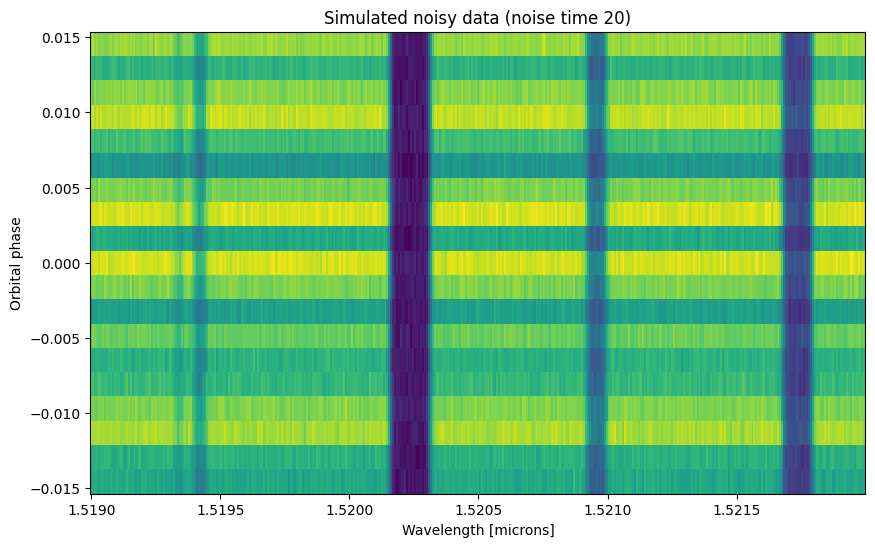

In [40]:
# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, noisy_data[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title(f"Simulated noisy data (noise time {noise_factor})")

Here you can see that the planet's spectral lines have become completely invisible, as we are dominated by the telluric lines. Note that the lines become slightly deeper as the orbital phase increase, this is the effect of the `airmass` we added above. Also note that in the case here, where we added the airmass specifically, the transmittance needs to be given at airmass = 1, and will then be scaled by `SpectralModel`.

## Preparing ground-based high-resolution spectra

<div class="alert alert-info">

The preparation step is controlled by the function `preparing_pipeline`. Spectral modification function map key: `prepare`.
</div>

When retrieving high-resolution data, preparing the forward model is a crucial step. For a detailed retrieval framework at high-resolution, see the ["High-resolution retrieval workflow with SpectralModel" section](./retrieval_spectral_model.html).

The default petitRADTRANS preparing pipeline "Polyfit" uses polynomial fits on wavelengths (for each exposure), then on times (for each wavelength) to remove the `instrumental_deformations` and `telluric_transmittances`. See [Blain et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167..179B/abstract) for more information.

Let's import `polyfit` first.

In [41]:
from petitRADTRANS.retrieval.preparing import polyfit

We will build the same spectrum without noise so we can see the result on the lines, and use the preparing pipeline on it. This will simulate noiseless prepared data.

In [42]:
# Noiseless simulated data
data_wavelengths, data = spectral_model.calculate_spectrum(
    mode='transmission',
    telluric_transmittances_wavelengths=telluric_transmittances_wavelengths,
    telluric_transmittances=telluric_transmittances,
    instrumental_deformations=instrumental_deformations,
    noise_matrix=None,  # no noise so we can see the lines
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True,
    prepare=False  # if the data were loaded, a preparation could not be done rigth away
)

# The data and its uncertainties must be masked arrays
data = np.ma.masked_array(data)
data_uncertainties = np.ma.masked_array(data_uncertainties)

# You can mask for example invalid pixels, here we will mask nothing
data.mask = np.zeros(data.shape, dtype=bool)
data_uncertainties.mask = np.zeros(data_uncertainties.shape, dtype=bool)

# Prepare the loaded data
prepared_data, preparation_matrix, prepared_data_uncertainties = polyfit(
    spectrum=data,
    uncertainties=data_uncertainties,
    wavelengths=data_wavelengths,
    airmass=airmass,
    tellurics_mask_threshold=spectral_model.model_parameters['tellurics_mask_threshold'],
    polynomial_fit_degree=spectral_model.model_parameters['polynomial_fit_degree'],
    full=True,
    apply_throughput_removal=True,
    apply_telluric_lines_removal=True
)

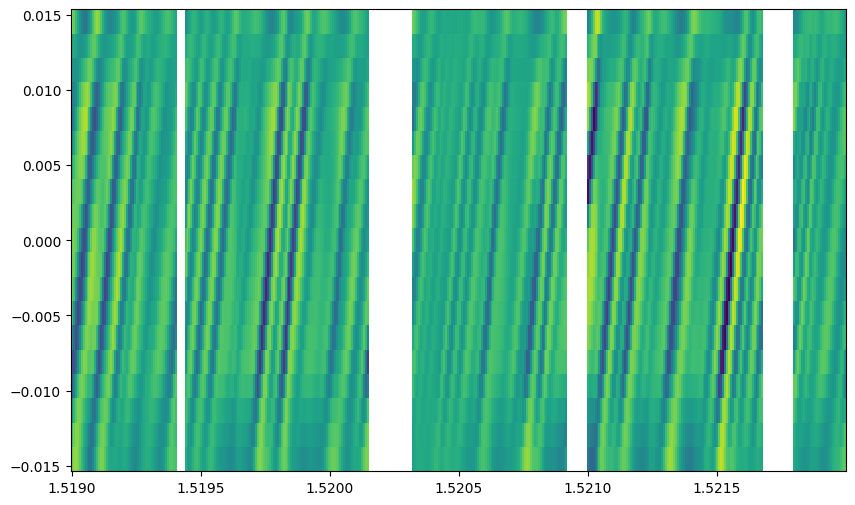

In [43]:
# Plot the prepared data
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(data_wavelengths[0] * 1e4, orbital_phases, prepared_data[0])# Get simulated noiseless data (instead you would load the data here)

We get the lines again, but they are deformed by the preparing pipeline.


To get a prepared forward model, you can use the `prepare` argument of `calculate_spectrum`:

In [44]:
# Simulated prepared noiseless data
wavelengths_rebinned, prepared_model = spectral_model.calculate_spectrum(
    mode='transmission',
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True,
    prepare=True
)

Text(0.5, 1.0, 'Prepared model')

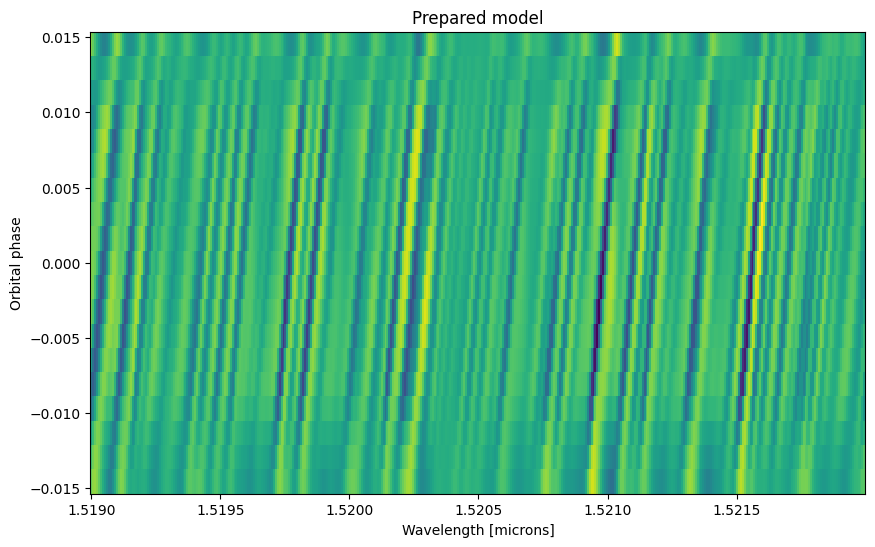

In [45]:
# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, prepared_model[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title('Prepared model')

<div class="alert alert-info">

In general, preparing pipelines performs better when the number of exposures and of wavelengths is higher, because the fit of the large trends in the data will be better. However, it is better to retrieve prepared data only where there is expected planet spectral information, i.e. for transmission spectra, within (or closely around) the exposures containing the primary transit.
</div>

To compare pipelines, the Bias Pipeline Metric (BPM, see [Blain et al. 2024](https://arxiv.org/abs/2402.14001)) can be used. It can be calculated via:

In [46]:
from petitRADTRANS.retrieval.preparing import bias_pipeline_metric

bpm = bias_pipeline_metric(
    prepared_true_model=prepared_model,
    prepared_mock_observations=prepared_data,
    mock_observations_preparation_matrix=preparation_matrix,
    mock_noise=None  # we are comparing with the noiseless simulated prepared data
)

print(f"BPM: {np.mean(np.abs(bpm)):.2e}")

BPM: 1.28e-06


The pipeline that has the mean absolute BPM the closest to 0 for a given set of simulated data can be seen as the most performant.

## Saving and loading

You can also save your `SpectralModel` for reproducibility or latter usage.

<div class="alert alert-block alert-warning">

Currently `SpectralModel` does not save custom functions: it is assumed that the default `SpectralModel` has been used.
</div>

In [47]:
# Save the model
file_name = os.path.join('.', 'generated_files', 'my_model.h5')

spectral_model.save(file_name)

If you want to reload your `SpectralModel` with all of its `model_parameters`, simply use:

In [48]:
spectral_model_loaded = SpectralModel.load(file_name)

Converting pressures from CGS to bar for Radtrans input...
Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__POKAZATEL.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2--H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2--He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... D

We can check that the loaded `SpectralModel` is in the same state as the local one:

In [49]:
loaded_wavelengths, loaded_model = spectral_model_loaded.calculate_spectrum(
    **spectral_model_loaded.model_parameters['modification_arguments']
)

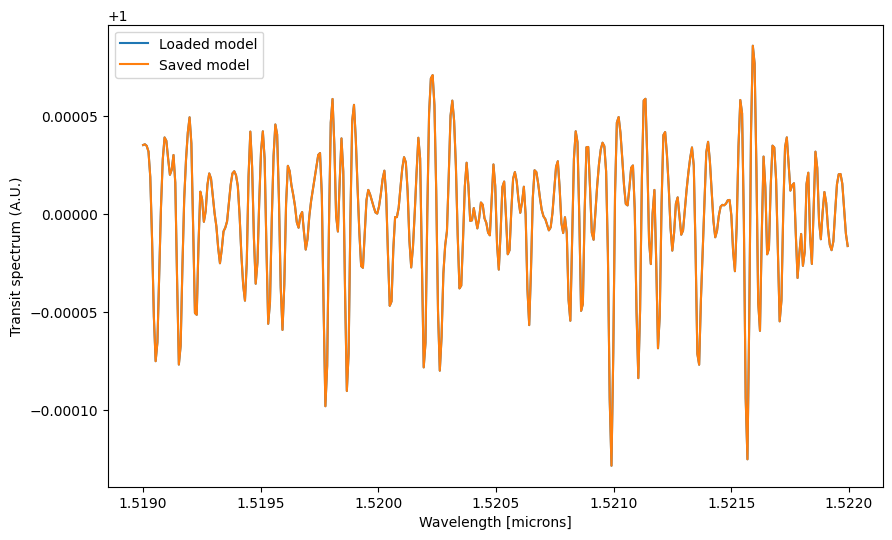

In [50]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(loaded_wavelengths[0] * 1e4, loaded_model[0, 10], label='Loaded model')
ax.plot(wavelengths_rebinned[0] * 1e4, prepared_model[0, 10], label='Saved model')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Transit spectrum (A.U.)')
ax.legend()

## Modifying the model functions and the spectral modification functions

All built-in `SpectralModel` functions can be customised.

<div class="alert alert-block alert-warning">

**All** the customised `SpectralModel` functions **must** include a `**kwargs` argument (e.g. `def my_function(..., **kwargs): ...`).
</div>

There are two ways of proceeding:
1. The preferred way is to use the `model_functions_map` and `spectral_modification_functions_map` attributes, both at, or after instantiation.
2. Alternatively, the `SpectralModel` functions can be modified by directly updating the corresponding attributes.

To demonstrate this, let's first generate a custom temperature profile function from a bleeding-edge model.

In [51]:
# Set a new temperature profile function based on some top-notch physics
def my_t_profile(pressures, my_parameter, x, **kwargs):  # the **kwargs is important, even if it's not used
    # Note that the "temperature" model parameter is not necessary, but in this context it could be used in place of "x"
    print("Calculating custom temperature...")
    return x * (1 + 0.3 * np.sin(np.deg2rad(my_parameter * np.log(pressures))))

def calculate_x(another_parameter, **kwargs):
    # The complex parameter x requires its own function to be accurately calculated
    print("Calculating x...")
    return another_parameter * 2

### From instantiation

We can generate from scratch a new `SpectralModel` including this function.

In [52]:
custom_spectral_model_1 = SpectralModel(
    # Temperature profile parameters
    my_parameter=50,  # 'my_parameter' is fixed and does not need to be calculated
    another_parameter=600,  # same for 'another_parameter'
    model_functions_map={
        'temperatures': my_t_profile,  # which function to use to calculate the 'temperatures' spectral parameter
        'x':  calculate_x  # which function to use to calculate the 'x' model parameter, used in my_t_profile
    },
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2--H2', 'H2--He'],
    wavelength_boundaries=[0.3, 15],
    # SpectralModel additional parameters
    # Planet parameters
    planet_radius=1 * cst.r_jup_mean,
    reference_gravity=10 ** 3.5,
    reference_pressure=1e-2,
    # Mass fractions
    imposed_mass_fractions={  # these can also be arrays of the same size as pressures
        'H2O': 1e-3,
        'CO-NatAbund': 1e-2,
        'CH4': 1e-5,
        'CO2': 1e-4,
        'Na': 1e-4,
        'K': 1e-6
    },
    filling_species={  # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12
        'H2': 37, 
        'He': 12
    }
)

Loading Radtrans opacities...
 Done.ng line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable.petitRADTRANS.h5'

Then, we generate the model as usual.

In [53]:
# Get the model
wavelengths, transit_radii_new_tp = custom_spectral_model_1.calculate_spectrum(
    mode='transmission'
)

Calculating x...
Calculating custom temperature...


The parameter `x` has been calculated from `calculate_x` before the temperatures (`my_t_profile`), because the latter requires the former as input. The model functions execution order is automatically determined from a [topological sorting algorithm](https://en.wikipedia.org/wiki/Topological_sorting#:~:text=In%20computer%20science%2C%20a%20topological,before%20v%20in%20the%20ordering.). The order at which the model functions are called can be accessed through the attribute `model_functions_map`.

<div class="alert alert-warning">

An error will be raised if a looping dependency is detected. A looping model function order with a convergence threshold (e.g for a self-consistent model) can technically be set by using a custom `compute_spectral_parameters` function.
</div>

Let's plot the results.

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

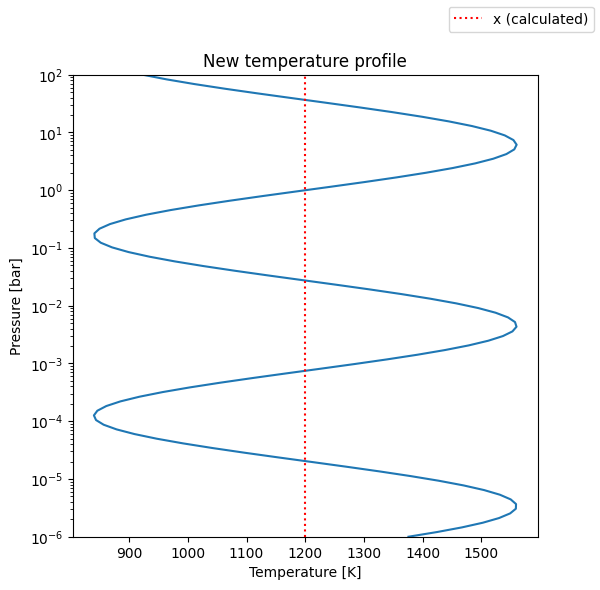

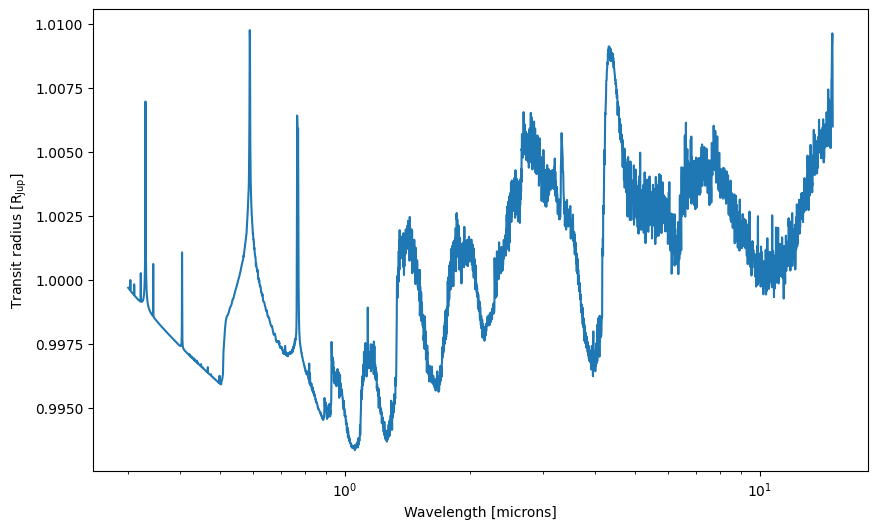

In [54]:
# Save custom temperatures
custom_temperatures_1 = copy.deepcopy(custom_spectral_model_1.temperatures)

# Plot the new temperature profile
fig, ax = plt.subplots(figsize = (6,6))

ax.semilogy(custom_temperatures_1, custom_spectral_model_1.pressures * 1e-6)
ax.vlines(custom_spectral_model_1.model_parameters['x'], custom_spectral_model_1.pressures[0] * 1e-6, custom_spectral_model_1.pressures[-1] * 1e-6, color='r', linestyle=':', label='x (calculated)')

ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bar]')
ax.set_ylim(np.array([custom_spectral_model_1.pressures[0], custom_spectral_model_1.pressures[-1]]) * 1e-6)
ax.set_title('New temperature profile')
fig.legend()

# Plot the new spectrum profile
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii_new_tp[0] / cst.r_jup_mean)

ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

### After instantiation

#### Using the `map`s attributes (not recommended)

Functions can also be modified after instantiation. We can, for example, revert our custom temperature function to the default built-in one. 

Of course, in that case we also need first to add the `temperature` model parameter.

In [55]:
custom_spectral_model_1.model_parameters['temperature'] = 1200
custom_spectral_model_1.update_model_functions_map({'temperatures': SpectralModel.compute_temperatures})

<div class="alert alert-info">

In that case, model parameters `x`, `my_parameter`, and `another_parameter` become useless, as will be indicated when executing `custom_spectral_model_1.get_model_parameters()`. This is why this method is not recommended.
</div>

Let's now re-generate the spectrum and plot the results.

In [56]:
# Get the model
wavelengths, transit_radii_default_tp = custom_spectral_model_1.calculate_spectrum(
    mode='transmission'
)

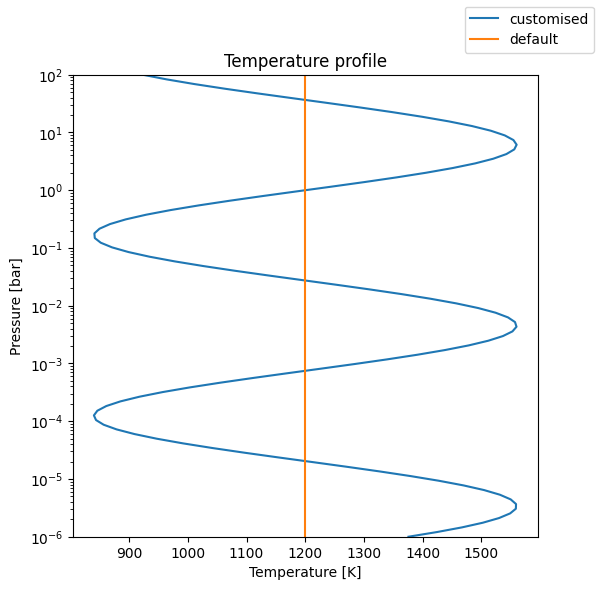

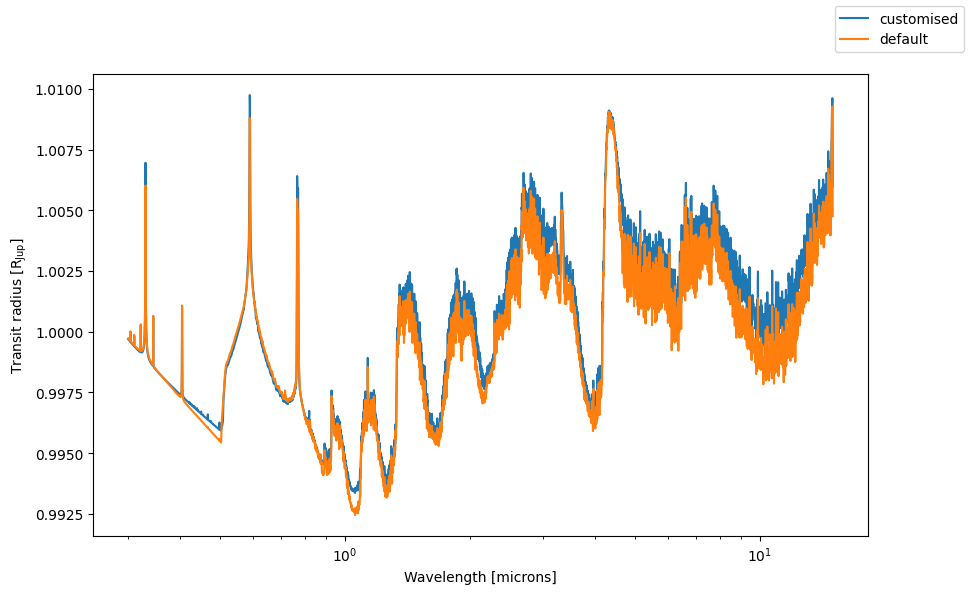

In [57]:
# Plot the new temperature profile
fig, ax = plt.subplots(figsize = (6,6))

ax.semilogy(custom_temperatures_1, custom_spectral_model_1.pressures * 1e-6, label='customised')
ax.semilogy(custom_spectral_model_1.temperatures, custom_spectral_model_1.pressures * 1e-6, label='default')

ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bar]')
ax.set_ylim(np.array([custom_spectral_model_1.pressures[0], custom_spectral_model_1.pressures[-1]]) * 1e-6)
ax.set_title('Temperature profile')
fig.legend()

# Plot the new spectrum profile
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii_new_tp[0] / cst.r_jup_mean, label='customised')
ax.plot(wavelengths[0] * 1e4, transit_radii_default_tp[0] / cst.r_jup_mean, label='default')

ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')
fig.legend()

#### Direct modification (not recommended)

The last and least recommended method is to directly modify the function.

First, let's copy the first custom spectral model to make comparisons easier.

In [58]:
# Copy the SpectralModel (not mandatory)
custom_spectral_model_2 = copy.deepcopy(custom_spectral_model_1)

Let's now customise the function.

<div class="alert alert-block alert-warning">

Do not forget to **update the model functions map** to ensure that the function execution order is correct, and to **add the relevant model parameters**.
</div>

In [59]:
# Add necessary model parameters for the new TP model
custom_spectral_model_2.model_parameters['my_parameter'] = 30  # use a slightly different value than before
custom_spectral_model_2.model_parameters['x'] = 1200  # x is actually not that complex, so let's give it a simple value

# Modify the temperature profile of the model
custom_spectral_model_2.compute_temperatures = my_t_profile  
custom_spectral_model_2.update_model_functions_map(update_model_parameters=False)

Finally, let's calculate the spectrum and plot it.

In [60]:
# Get the model
wavelengths, transit_radii_new_tp_2 = custom_spectral_model_2.calculate_spectrum(
    mode='transmission'
)

Calculating custom temperature...


Text(0.5, 1.0, 'New spectrum')

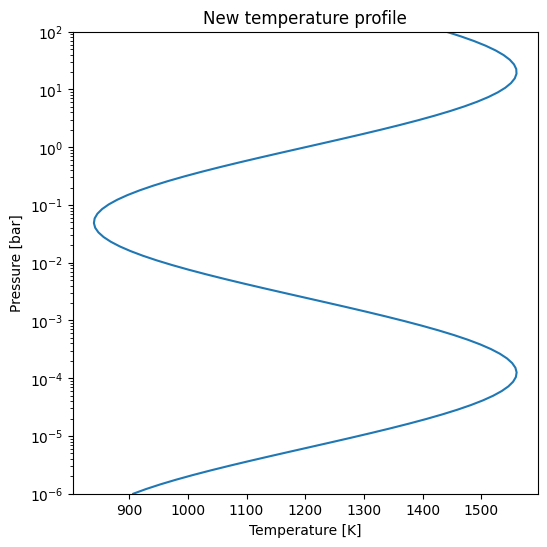

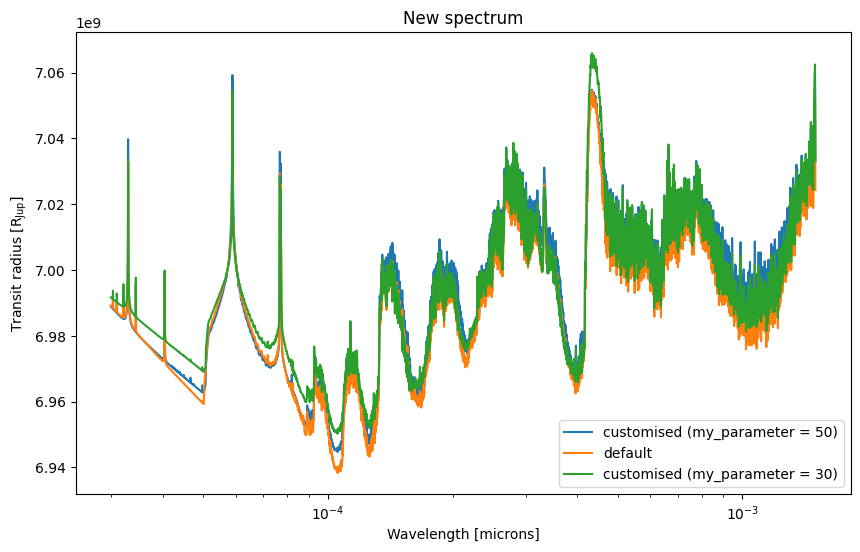

In [61]:
# Plot the new temperature profile
fig, ax = plt.subplots(figsize = (6,6))

ax.semilogy(custom_spectral_model_2.temperatures, custom_spectral_model_2.pressures * 1e-6)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bar]')
ax.set_ylim(np.array([custom_spectral_model_2.pressures[0], custom_spectral_model_2.pressures[-1]]) * 1e-6)
ax.set_title('New temperature profile')

# Plot the new spectrum profile
fig, ax = plt.subplots(figsize = (10,6))

ax.semilogx(wavelengths[0], transit_radii_new_tp[0], label=f"customised (my_parameter = {custom_spectral_model_1.model_parameters['my_parameter']})")
ax.semilogx(wavelengths[0], transit_radii_default_tp[0], label='default')
ax.semilogx(wavelengths[0], transit_radii_new_tp_2[0], label=f"customised (my_parameter = {custom_spectral_model_2.model_parameters['my_parameter']})")

ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')
ax.legend()
ax.set_title('New spectrum')

### Example: changing the preparing pipeline from Polyfit to SysRem


<div class="alert alert-block alert-warning">

We **do not** recommend to use SysRem with `SpectralModel`'s **retrieval** framework (i.e., modifying the forward model in the same way as the data). More information is available in [Blain et al. 2024 (Appendix B)](https://doi.org/10.3847/1538-3881/ad2c8b). For **CCF analysis**, as long as the template spectrum is **not** prepared, we have no preparing pipeline recommendation.
</div>

We will use the instantiation method, but all other methods presented previously can work as well. See [Blain et al. 2024 (Appendix B)](https://doi.org/10.3847/1538-3881/ad2c8b) for more details on this SysRem ([Tamuz et al. 2005](https://doi.org/10.1111/j.1365-2966.2004.08585.x)) implementation.

<div class="alert alert-info">

Since the preparing step is a [**modification** function](#Spectral-modification-functions) and not a [**model** function](#Model-functions), the attribute to use is `spectral_modification_functions_map`.
</div>

First, let's import SysRem.

In [62]:
from petitRADTRANS.retrieval.preparing import sysrem

Since in petitRADTRANS, SysRem requires a **masked** spectrum array as input, and that spectra out of `Radtrans` are simple arrays, we will make a wrapper to mask the array.

In [63]:
# Make a wrapper so that the input spectrum is a masked array
def sysrem_wrapper(spectrum, uncertainties, n_passes, 
           n_iterations_max, convergence_criterion,
           tellurics_mask_threshold, polynomial_fit_degree, **kwargs):
    _spectrum = np.ma.masked_array(spectrum)
    
    return sysrem(
        spectrum=_spectrum,
        uncertainties=uncertainties,
        n_passes=n_passes, 
        n_iterations_max=n_iterations_max, 
        convergence_criterion=convergence_criterion,
        tellurics_mask_threshold=tellurics_mask_threshold, 
        polynomial_fit_degree=polynomial_fit_degree,
        full=True,
        **kwargs
    )

Let's now instantiate our `SpectralModel`. Note that we add SysRem's specific parameters as model parameters.

In [64]:
spectral_model = SpectralModel(
    # Preparation parameters
    spectral_modification_functions_map={
        'prepare': sysrem_wrapper  # modify the preparation step
    },
    n_passes=10,
    n_iterations_max=300,
    convergence_criterion=1e-15,
    tellurics_mask_threshold=0.8,  # mask the fitted transmittances if it is below this value
    polynomial_fit_degree=2,  # degree of the polynomial fit
    uncertainties=data_uncertainties,
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CO-NatAbund', 
        'H2O' 
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2--H2', 'H2--He'],
    line_opacity_mode='lbl',
    line_by_line_opacity_sampling=4,
    # SpectralModel parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=1e-2,
    star_radius=planet.star_radius,
    transit_duration=planet.transit_duration,
    orbital_period=planet.orbital_period,
    # Velocity paramters
    star_mass=planet.star_mass,
    orbit_semi_major_axis=planet.orbit_semi_major_axis,
    orbital_inclination=planet.orbital_inclination,
    rest_frame_velocity_shift=-5e5,  # (cm.s-1) V_rest
    system_observer_radial_velocities=star_radial_velocity - barycentric_velocities,
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=1e-2,  # added opaque cloud
    # Mass fractions
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CO-NatAbund': 1e-2,
        'H2O': 1e-3,
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=data_wavelengths,  # (cm) used for the rebinning, and also to set the wavelengths boundaries
    rebin_range_margin_power=4,  # used to set the wavelengths boundaries, adding a margin of ~1 Angstrom (1e-4 * ~1 µm)
    convolve_resolving_power=8e4,  # used for the convolution
    mid_transit_time=mid_transit_time,
    times=times
)

Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__POKAZATEL.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2--H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2--He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully lo

Let's now calculate the **prepared** spectrum (here, noisy simulated data), and plot the result.

In [65]:
# Simulated prepared data
wavelengths_rebinned, prepared_model = spectral_model.calculate_spectrum(
    mode='transmission',
    telluric_transmittances_wavelengths=telluric_transmittances_wavelengths,
    telluric_transmittances=telluric_transmittances,
    instrumental_deformations=instrumental_deformations,
    noise_matrix=noise_matrix,
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True,
    prepare=True
)

Text(0.5, 1.0, 'Prepared noisy model')

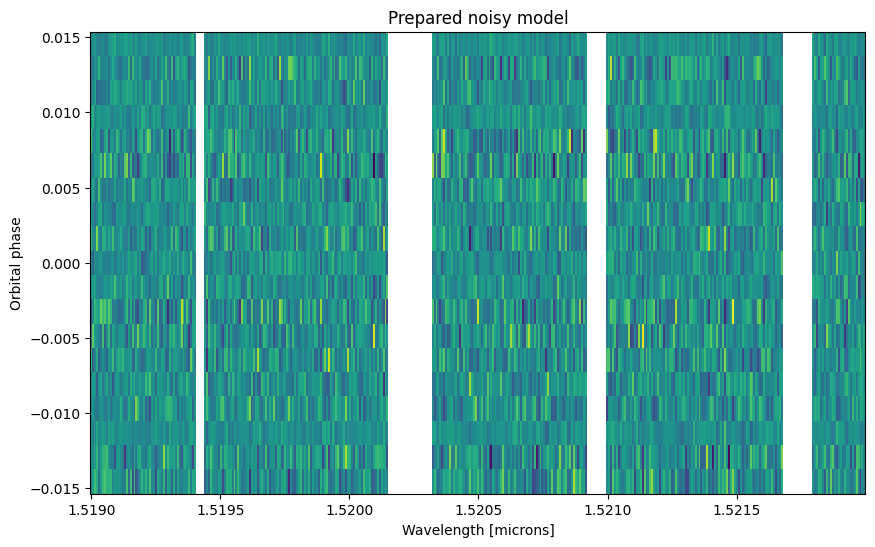

In [66]:
# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, prepared_model[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title('Prepared noisy model')

## Useful tips

We will use the `SpectralModel` for emission spectra in these examples.

In [67]:
spectral_model = spectral_model_emission

### Modifying model parameters without instatiating a new `SpectralModel`

You can change the value of any [model parameter](#Model-parameters) (or add an entierly new model parameter) of an existing `SpectralModel` very simply. For example, if you want to modify the Guillot temperature profile:

In [68]:
# Update model parameters
spectral_model.model_parameters['temperature'] = 3000
spectral_model.model_parameters['guillot_temperature_profile_gamma'] = 2.0

# Generate updated spectrum
wavelengths_updated, flux_updated = spectral_model.calculate_spectrum(
    mode='emission'
)

Text(0, 0.5, 'Observerved planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

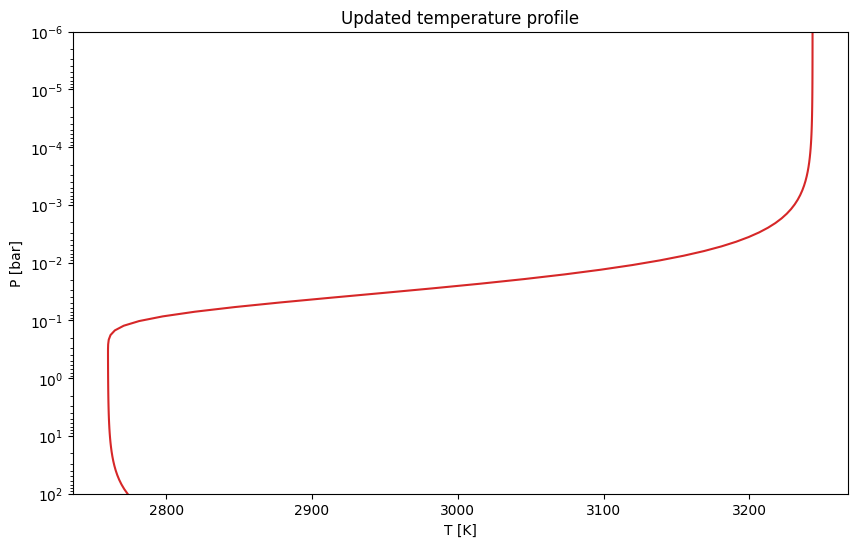

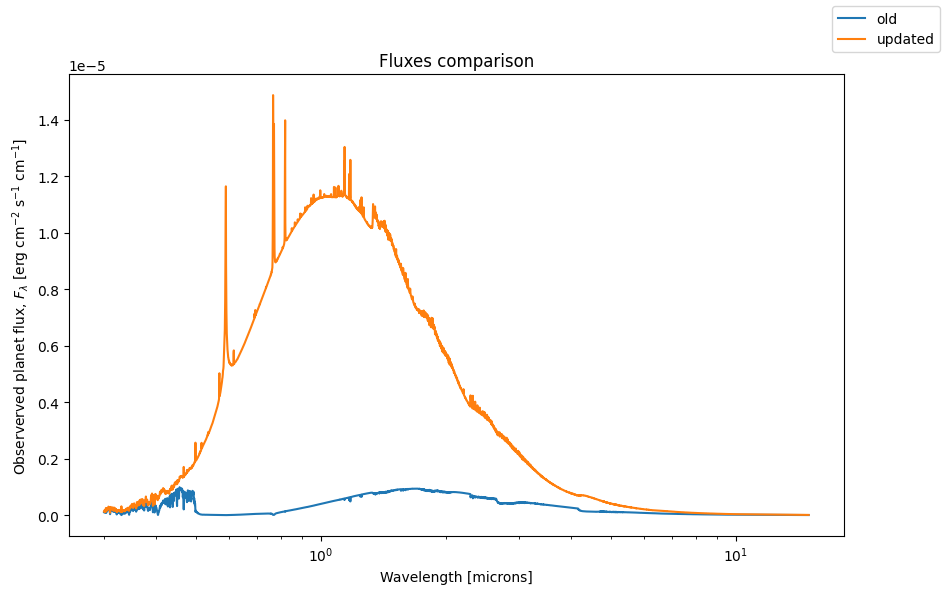

In [69]:
# Plot updated temperature profile
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(spectral_model.temperatures, spectral_model.pressures * 1e-6, color='C3')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_title('Updated temperature profile')
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')

# Plot flux comparison
fig, ax = plt.subplots(figsize = (10,6))

ax.semilogx(wavelengths[0] * 1e4, flux[0], label='old')
ax.semilogx(wavelengths_updated[0] * 1e4, flux_updated[0], label='updated')

fig.legend()
ax.set_title('Fluxes comparison')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Observerved planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

<div class="alert alert-info">

You can update the model and spectral parameters without generating a new spectrum using `spectral_model.update_spectral_calculation_parameters(**spectral_model.model_parameters)`.
</div>

Note that, because we used equilibrium chemistry in `spectral_model`, the mass fractions, (as well as all the parameters depending on the temperature, the parameters depending on those, and so on), has been updated as well. The $\rm H_2O$ mass fractions, which we imposed and does not depends on the temperature, has not changed.

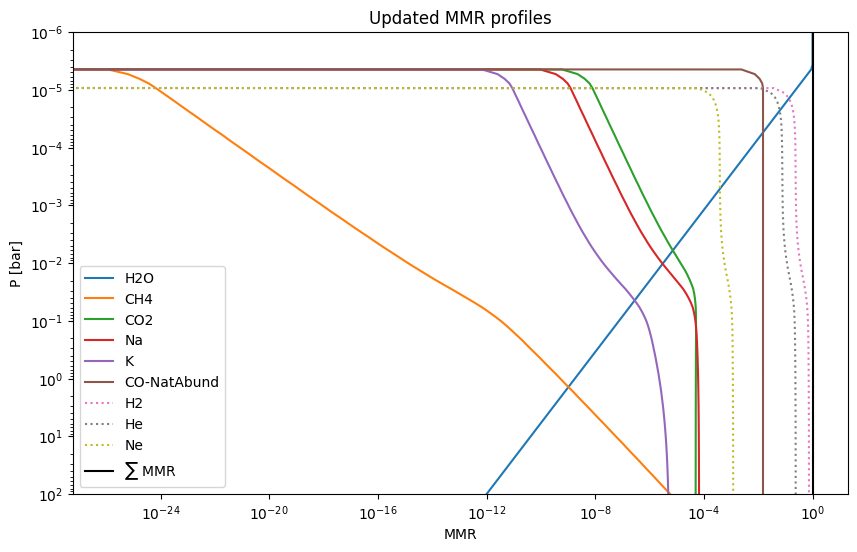

In [70]:
fig, ax = plt.subplots(figsize = (10,6))

for species, mass_fraction in spectral_model.mass_fractions.items():
    if species in spectral_model.line_species:
        ax.loglog(mass_fraction, spectral_model.pressures * 1e-6, label=species)

for species, mass_fraction in spectral_model.mass_fractions.items():
    if species in spectral_model.model_parameters['filling_species']:
        ax.loglog(mass_fraction, spectral_model.pressures * 1e-6, label=species, ls=':')

ax.loglog(np.sum(list(spectral_model.mass_fractions.values()), axis=0), spectral_model.pressures * 1e-6, label=r'$\sum$ MMR', color='k')
    
ax.set_ylim([1e2, 1e-6])
ax.set_title('Updated MMR profiles')
ax.set_xlabel('MMR')
ax.set_ylabel('P [bar]')
ax.legend()

### Not updating parameters

You can choose to prevent the [spectral parameter](#Spectral-parameters) update (and any [model parameter](#Model-parameters) calculated by a [model function](#Model-functions)) when calculating a spectrum by setting `update_parameters=False`:

Text(0, 0.5, 'Observerved planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

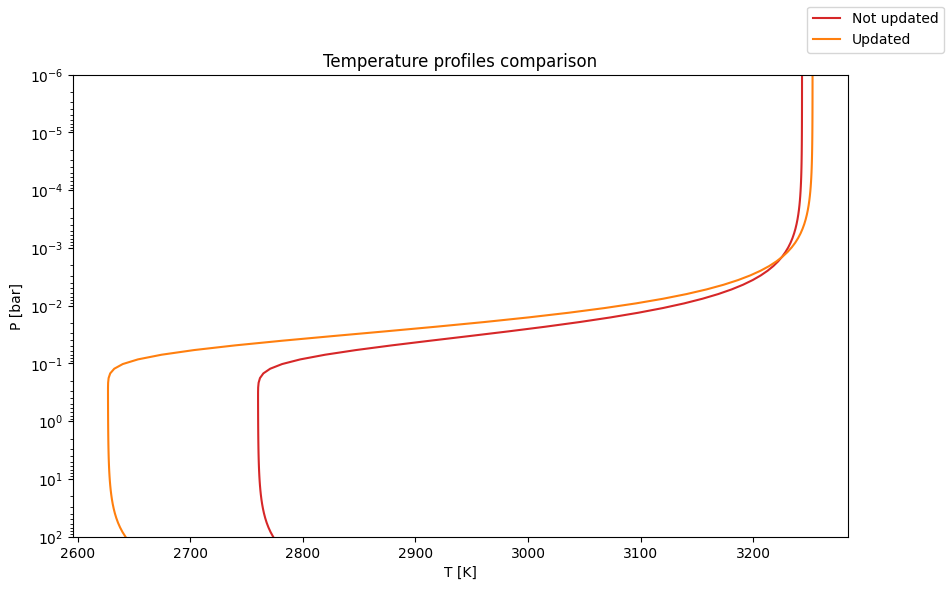

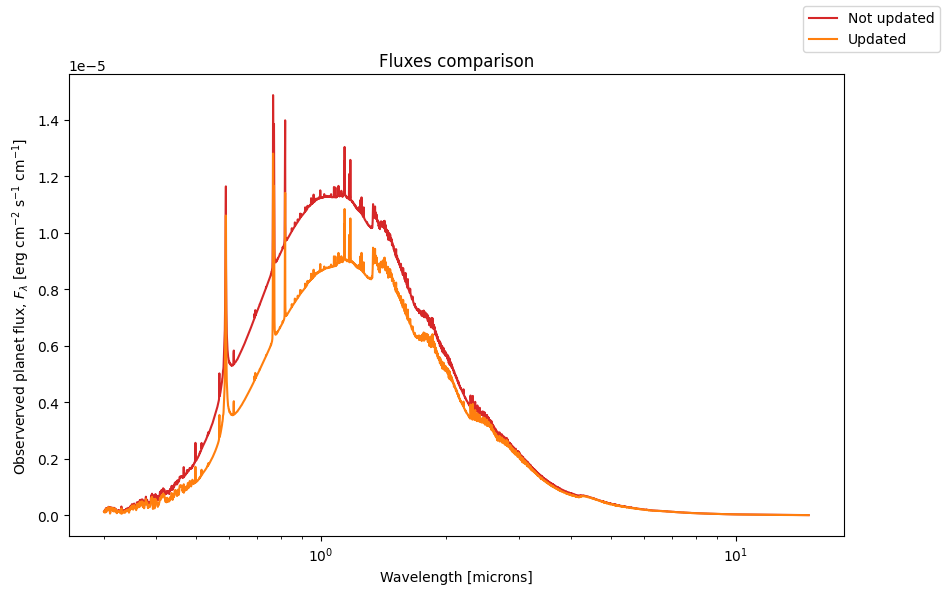

In [71]:
# Modify some model parameters
spectral_model.model_parameters['temperature'] = 2900
spectral_model.model_parameters['guillot_temperature_profile_gamma'] = 2.5

# Generate non-updated spectrum
wavelengths_not_updated, flux_not_updated = spectral_model.calculate_spectrum(
    mode='emission',
    update_parameters=False
)

# Plot non-updated temperature profile
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(spectral_model.temperatures, spectral_model.pressures * 1e-6, label='Not updated', color='C3')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_title('Temperature profiles comparison')
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')


# Generate updated spectrum
wavelengths_updated, flux_updated = spectral_model.calculate_spectrum(
    mode='emission',
    update_parameters=True  # True by default
)

# Plot updated temperature profile
ax.plot(spectral_model.temperatures, spectral_model.pressures * 1e-6, label='Updated', color='C1')
fig.legend()

# Plot fluxes
fig, ax = plt.subplots(figsize = (10,6))

ax.semilogx(wavelengths_not_updated[0] * 1e4, flux_not_updated[0], label='Not updated', color='C3')
ax.semilogx(wavelengths_updated[0] * 1e4, flux_updated[0], label='Updated', color='C1')

fig.legend()
ax.set_title('Fluxes comparison')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Observerved planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

### Returning the `Radtrans` additional outputs

By default, `SpectralModel.calculate_spectrum` only outputs the wavelengths array and the spectra array.

To get the additional outputs dictionary, add `return_additional_outputs=True` when calling `calculate_spectrum`. In that case, the function will return 3 variables corresponding to the wavelengths, the spectra, and the additional outputs dict, respectively. Arguments such as `return_contribution` can be added as model parameters.

In [72]:
spectral_model.model_parameters['return_contribution'] = True  # can also be set during the instantiation

wavelengths, transit_radii, additional_outputs = spectral_model.calculate_spectrum(
    mode='emission',
    return_additional_outputs=True
)

Text(0.5, 1.0, 'Emission contribution function')

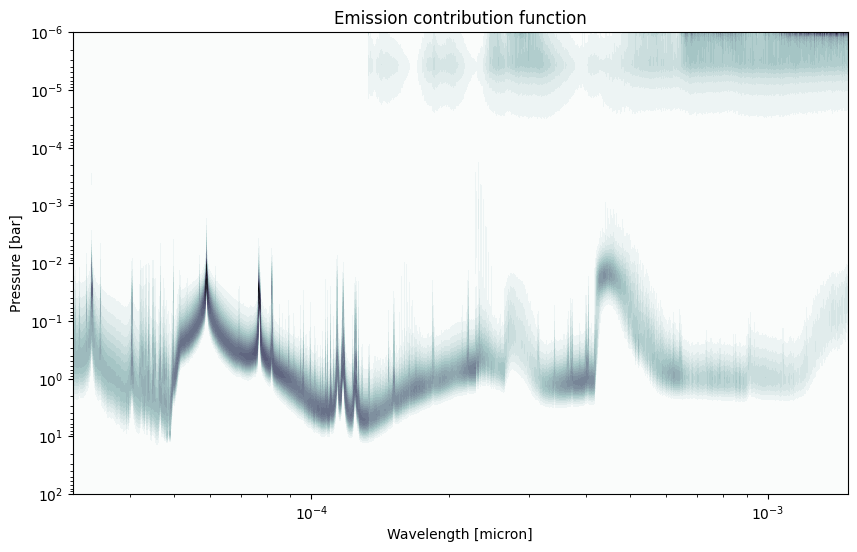

In [73]:
x, y = np.meshgrid(wavelengths, spectral_model.pressures * 1e-6)

fig,ax = plt.subplots(figsize=(10,6))
ax.contourf(x, y, additional_outputs['emission_contribution'], 30, cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2,1e-6])
ax.set_xlim([np.min(wavelengths),np.max(wavelengths)])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Emission contribution function')